# Dependencies and imports

In [ ]:
%pip install yfinance

In [1]:
import yfinance
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2
import warnings

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

# Suppress specific UserWarnings related to statsmodels
warnings.filterwarnings("ignore", module='statsmodels')



/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Gather S&P500 prices and returns

In [3]:
####### USE CSV FILES
# df = pd.read_csv('SP500_Prices.csv', sep='\t')
# df.Date = pd.Series([pd.Timestamp(date) for date in df.Date])
# df = df.set_index('Date')
# df['returns'] = df.market_value.pct_change(1).mul(100)
# df=df.iloc[1:]
# start_date = df.index.min()
# end_date = df.index.max()
# business_days = pd.date_range(start=start_date, end= end_date, freq='B')
# df = df.reindex(business_days).ffill()

####### USE yfinance
df = yfinance.download("^GSPC",start='1990-01-01')
df['market_value'] = df.Close
df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df[1:]

start_date = df.index.min()
end_date = df.index.max()
business_days = pd.date_range(start=start_date, end= end_date, freq='B')

df = df.reindex(business_days).ffill()
df

[*********************100%%**********************]  1 of 1 completed


,market_value,returns
1990-01-03,358.760010,-0.258554
1990-01-04,355.670013,-0.861299
1990-01-05,352.200012,-0.975624
1990-01-08,353.790009,0.451447
1990-01-09,349.619995,-1.178669
...,...,...
2024-03-22,5234.180176,-0.140219
2024-03-25,5218.189941,-0.305496
2024-03-26,5203.580078,-0.279980
2024-03-27,5248.490234,0.863063


# Plot prices and returns

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df.index, df.market_value)
plt.title("S&P500 Prices")
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df.returns, lw=0.5)
plt.title("S&P500 Returns")
plt.show()

# Dickey-Fuller Augumented


adfuller -> (
    ADF,
    p,
    lags,
    obs,
    {critical values},
    resstore
)

* If the **ADF** value is lower than the **critical values** and **p** is less than **0.05** it means that the null hypotisis is rejected. So the time series is **stationary**.

In [ ]:
adfuller_price_result = sts.adfuller(df.market_value)
adfuller_returns_result = sts.adfuller(df.returns)

def is_stationary(adfuller_result):
    adf = adfuller_result[0]
    p = adfuller_result[1]
    critical_value = adfuller_result[4]['5%']
    return adf < critical_value and p < 0.05

def print_adfuller_result(adfuller_result):
    adf = adfuller_result[0]
    p = adfuller_result[1]
    lags = adfuller_result[2]
    observed = adfuller_result[3]
    print(f"ADF: {adf}\nP: {p}\nLags: {lags}\nObserved: {observed}")

print(f"======= Dickey-Fuller Augumented for Prices ========")
print_adfuller_result(adfuller_price_result)
print(f"\t-->Is Stationary: {is_stationary(adfuller_price_result)}")

print(f"\n\n======= Dickey-Fuller Augumented for Returns ========")
print_adfuller_result(adfuller_returns_result)
print(f"\t-->Is Stationary: {is_stationary(adfuller_returns_result)}")

# ARMA(P=1,Q=1)

**Summary of ARIMA(1,0,1) Model Fit for S&P500 Returns:**

```
Dep. Variable:	returns	            No. Observations:	8609
Model:	        ARIMA(1, 0, 1)	     Log Likelihood	-13332.016

Date:	        Wed, 06 Mar 2024	     AIC	26672.032
Time:	        21:44:33	             BIC	26700.275
Sample:	0 - 8609	                   HQIC	26681.664

Covariance Type:	opg

           coef	| std err |	  z	 |   P>|z|    | [0.025	  0.975]
---------------------------------------------------------------------------
const	| 0.0374  | 0.012   | 3.212	  | 0.001	  | 0.015	  0.060
ar.L1	| 0.2730  | 0.050   | 5.431	  | 0.000	  | 0.175	  0.372
ma.L1	|-0.3539  | 0.049   | -7.255	 | 0.000	  | -0.450	 -0.258
sigma2   |1.2961   | 0.008   | 152.984	| 0.000	  | 1.279	  1.313
---------------------------------------------------------------------------

Ljung-Box (L1) (Q):	    0.05	| Jarque-Bera (JB):	34801.44
           Prob(Q):	    0.83	| Prob(JB):	        0.00
Heteroskedasticity (H):	1.20	| Skew:	            -0.31
   Prob(H) (two-sided):	0.00	| Kurtosis:        	12.83
```


- **Model Explanation**: ARIMA(1,0,1) signifies an AutoRegressive Integrated Moving Average model, where '1' denotes one lag for the AR part and one lag for the MA part. The '0' indicates that the data does not need differencing, suggesting it is already stationary.
- **Sample Size**: 8609 observations were used to fit the model.
- **Coefficients**:
    - const: 0.0374 -> suggests a small positive average return over the period analyzed
    - ar.L1: 0.2730 -> indicates a positive relationship between the current return and the immediately preceding return
    - ma.L1: -0.3539 -> can be an indicative of a 'smoothing' effect

- **Standard Error**: between 0.08 and 0.050 -> suggests that the estimates of the coefficients are precise

- **z and P>|z| (p-value)**: The z-statistics test the null hypothesis that each coefficient is equal to zero. In this case, all p-values are very small (p < 0.001 for each coefficient), providing strong evidence against the null hypothesis, which suggests that all coefficients are significantly different from zero, suggesting they **meaningfully contribute to the model**.

- **Log Likelihood**: -13332.016 -> is a measure of the goodness of fit of the model.



---

**Model Selection Criteria: AIC, BIC, and HQIC**

In evaluating statistical models, we often consider the following criteria to select the optimal model:

- **AIC (Akaike Information Criterion)**: `26672.032` — lower values are better, indicating a model that explains the data well without overfitting.
- **BIC (Bayesian Information Criterion)**: `26700.275` — similar to AIC but includes a penalty for the number of observations, favoring simpler models as sample size grows.
- **HQIC (Hannan-Quinn Information Criterion)**: `26681.664` — balances between AIC and BIC, also penalizing complexity to prevent overfitting.


These criteria suggest our model achieves a good balance between accuracy and simplicity. In comparing models, we usually prefer the one with the lowest criteria values.



In [ ]:
model_ret_ar_1_ma_1 = ARIMA(df.returns, order=(1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
print(results_ret_ar_1_ma_1.summary())

# Log-Likelihood Ratio (LLR) Test



The LLR test is a hypothesis test to compare the goodness of fit of two competing statistical models. Here's a breakdown of how the test works and what it tells us:

### Purpose:
- The LLR test determines whether the addition of more parameters in a more complex model significantly improves the model's fit to the data compared to a simpler nested model.

### Process:
- **Log-Likelihoods (LL)**: Calculate the log-likelihoods for both models. The log-likelihood is a measure of how well the model fits the data; higher values indicate a better fit.
- **Likelihood Ratio (LR)**: Compute the difference between the log-likelihoods of the complex model (`mod_2`) and the simpler model (`mod_1`) and multiply by 2, i.e., `LR = 2 * (L2 - L1)`.
- **Degrees of Freedom (DF)**: The difference in the number of parameters between the complex and simpler models.

### Interpretation:
- The LR statistic follows a chi-squared distribution with degrees of freedom equal to the difference in the number of parameters between the two models.
- A low p-value (typically < 0.05) indicates that the more complex model provides a significantly better fit to the data.

### Python Function:
```python
from scipy.stats import chi2

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
```

- This function calculates the p-value for the LLR test.

- **mod_1** and **mod_2** are the two models being compared, where mod_2 is the more complex model.

- **DF** is the degrees of freedom, defaulting to 1 for comparing models that differ by one parameter. *(In the context of model comparisons, such as when you're using an LLR test to compare two nested models , the degrees of freedom often refer to the difference in the number of independent parameters between the two models.)*

- The function returns the p-value, which you can use to judge whether the difference in fit between the two models is statistically significant.

### Usage

- Use this test when you want to assess if an additional parameter in the model is justifiable by a significant increase in the likelihood of the data given the model.

In [ ]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
model_ret_ar_1 = ARIMA(df.returns, order=(1,0,0))
model_ret_ma_1 = ARIMA(df.returns, order=(0,0,1))

In [ ]:
print(f"ARMA(1,1) vs AR(1): {LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1, DF=1)}")
print(f"ARMA(1,1) vs MA(1): {LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1, DF=1)}")

In [ ]:
model_ret_ar_3_ma_3 = ARIMA(df.returns, order=(3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
results_ret_ar_3_ma_3.summary()

In [ ]:
print(f"ARMA(3,3) vs AR(1,1): {LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF=4)}")

# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are essential in identifying the order of Autoregressive (AR) and Moving Average (MA) components in time series data.

### ACF Plot for S&P500 Returns
- The ACF plot displays the correlation of the series with its own lagged values. Each point on the plot represents the lag between the time series and its own past values.
- The ACF plot is used to identify the MA component of time series models. The `lags` parameter was set to 40, and the `zero=False` parameter excludes the zeroth lag.

### PACF Plot for S&P500 Returns
- The PACF plot shows the partial correlation of the series with its own lagged values, controlling for the values of the time series at all shorter lags.
- PACF is used to identify the number of AR terms in ARIMA models. The lag values are also set to 40 here, similar to the ACF plot.

Both plots are important diagnostic tools in model selection and help to understand the underlying data generating process for the S&P500 returns.


In [ ]:
sgt.plot_acf(df.returns, lags=100, zero = False)
plt.title("ACF S&P500 Returns", size=24)
plt.autoscale()
plt.show()

In [ ]:
sgt.plot_pacf(df.returns, lags = 100, zero = False, method = ('ols'))
plt.title("PACF S&P500 Returns", size=24)
plt.autoscale()
plt.show()

# Manually test LLF and AIC

In [ ]:
model_ret_ar_3_ma_3 = ARIMA(df.returns, order=(3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

model_ret_ar_2_ma_2 = ARIMA(df.returns, order=(2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()

model_ret_ar_2_ma_3 = ARIMA(df.returns, order=(2,0,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()

model_ret_ar_3_ma_2 = ARIMA(df.returns, order=(3,0,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()

In [ ]:
print(f'ARMA(2,2)\n\tLLF = {results_ret_ar_2_ma_2.llf}\n\tAIC = {results_ret_ar_2_ma_2.aic}')
print(f'ARMA(2,3)\n\tLLF = {results_ret_ar_2_ma_3.llf}\n\tAIC = {results_ret_ar_2_ma_3.aic}')
print(f'ARMA(3,2)\n\tLLF = {results_ret_ar_3_ma_2.llf}\n\tAIC = {results_ret_ar_3_ma_2.aic}')
print(f'ARMA(3,3)\n\tLLF = {results_ret_ar_3_ma_3.llf}\n\tAIC = {results_ret_ar_3_ma_3.aic}')

In [ ]:
results_ret_ar_3_ma_3.summary()

# Residuals for Returns

In [ ]:
df['res_ret_ar_3_ma_3'] = results_ret_ar_3_ma_3.resid[:]
print(df['res_ret_ar_3_ma_3'])

In [ ]:
df['res_ret_ar_3_ma_3'].plot(figsize = (20,10), color='black')
plt.autoscale()
plt.title("Residuals of Returns", size=24)
plt.show()

In [ ]:
sgt.plot_acf(df['res_ret_ar_3_ma_3'], zero=False, lags=40)
plt.title("ACF Of Residuals for Returns", size=24)
plt.autoscale()
plt.show()

In [ ]:
model_ret_ar_8_ma_1 = ARIMA(df.returns, order=(8,0,1))
results_ret_ar_8_ma_1 = model_ret_ar_8_ma_1.fit()
results_ret_ar_8_ma_1.summary()

In [ ]:
model_ret_ar_1_ma_8 = ARIMA(df.returns, order=(1,0,8))
results_ret_ar_1_ma_8 = model_ret_ar_1_ma_8.fit()
results_ret_ar_1_ma_8.summary()

In [ ]:
model_ret_ar_8_ma_3 = ARIMA(df.returns, order=(8,0,3))
results_ret_ar_8_ma_3 = model_ret_ar_8_ma_3.fit()
results_ret_ar_8_ma_3.summary()

In [ ]:
model_ret_ar_7_ma_1 = ARIMA(df.returns, order=(7,0,1))
results_ret_ar_7_ma_1 = model_ret_ar_7_ma_1.fit()
results_ret_ar_7_ma_1.summary()

In [ ]:
print(f'ARMA(3,3)\n\tLLF = {results_ret_ar_3_ma_3.llf}\n\tAIC = {results_ret_ar_3_ma_3.aic}')
print(f'ARMA(8,1)\n\tLLF = {results_ret_ar_8_ma_1.llf}\n\tAIC = {results_ret_ar_8_ma_1.aic}')
print(f'ARMA(8,3)\n\tLLF = {results_ret_ar_8_ma_3.llf}\n\tAIC = {results_ret_ar_8_ma_3.aic}')
print(f'ARMA(7,1)\n\tLLF = {results_ret_ar_7_ma_1.llf}\n\tAIC = {results_ret_ar_7_ma_1.aic}')
print(f'ARMA(1,8)\n\tLLF = {results_ret_ar_1_ma_8.llf}\n\tAIC = {results_ret_ar_1_ma_8.aic}')

# ARMA(8,1) and Residuals

### Residuals for the New Model


In [ ]:
df['res_ret_ar_8_ma_1'] = results_ret_ar_8_ma_1.resid[:]
df['res_ret_ar_8_ma_1']

In [ ]:
df['res_ret_ar_8_ma_1'].plot(figsize = (20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [ ]:
sgt.plot_acf(df['res_ret_ar_8_ma_1'], zero=False, lags=40)
plt.title("ACF Of Residuals for Returns", size=24)
plt.ylim(-0.1,0.1)
plt.show()

In [ ]:
sgt.plot_pacf(df['res_ret_ar_8_ma_1'], zero=False, lags=40)
plt.title("ACF Of Residuals for Returns", size=24)
plt.ylim(-0.1,0.1)
plt.show()

# ARIMA

In [ ]:
len_ds = len(df.market_value)
train, test = df.market_value[:int(len_ds*0.90)], df.market_value[int(len_ds*0.90):]
model = ARIMA(train, order=(30,1,90))
results = model.fit()
print(results.summary())

prediction = results.predict(start=0, end=len_ds-1)

prediction.index=df.index
error = sum([(y-yp)**2 for y,yp in zip(test,prediction)])/len(test)
plt.figure(figsize=(20,10))
train.plot(label='Train',lw=1.5)
test.plot(label='Test',lw=0.5)
prediction.plot(label='Prediction',lw=0.5)

plt.title(f"MSE: {error}")
plt.legend()
plt.show()

## GET ARIMA BEST PARAMS

--------------------------------------------------


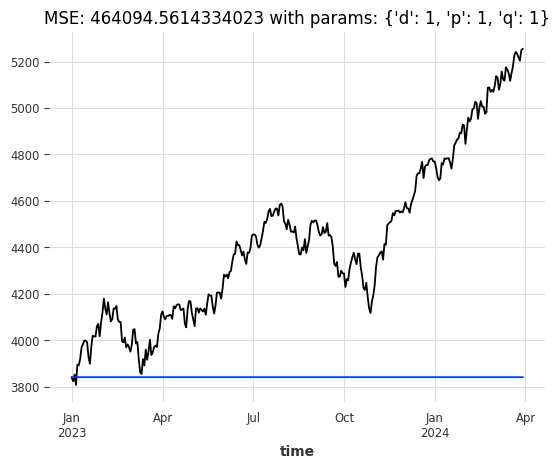

Iter: 0 took 0.692903995513916 with params {'d': 1, 'p': 1, 'q': 1}
--------------------------------------------------


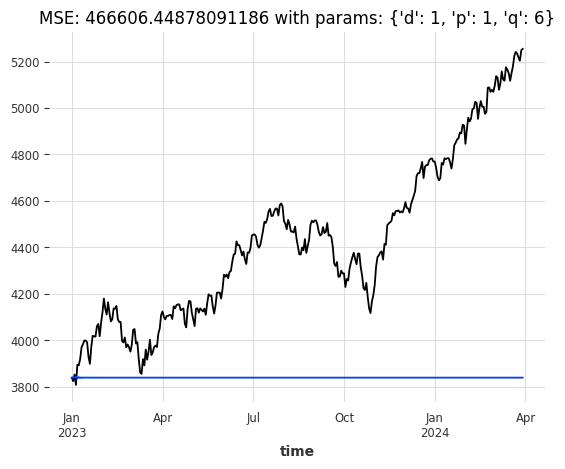

Iter: 1 took 1.4406840801239014 with params {'d': 1, 'p': 1, 'q': 6}
--------------------------------------------------


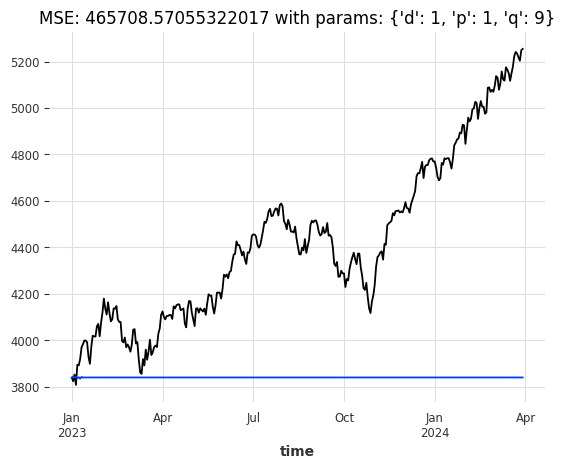

Iter: 2 took 2.0784292221069336 with params {'d': 1, 'p': 1, 'q': 9}
--------------------------------------------------


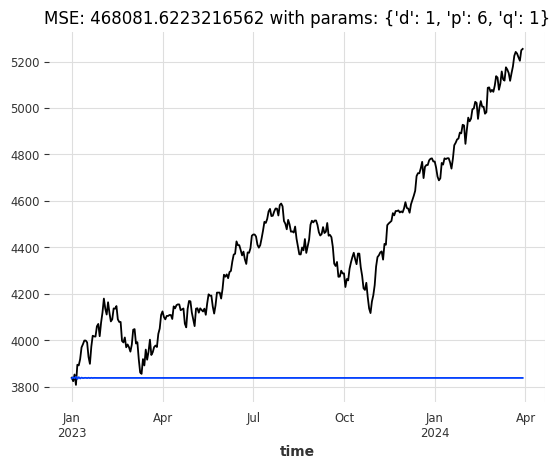

Iter: 3 took 1.8347830772399902 with params {'d': 1, 'p': 6, 'q': 1}
--------------------------------------------------


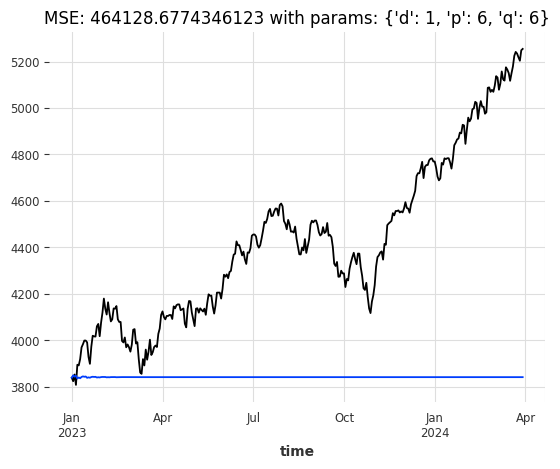

Iter: 4 took 4.532685279846191 with params {'d': 1, 'p': 6, 'q': 6}
--------------------------------------------------


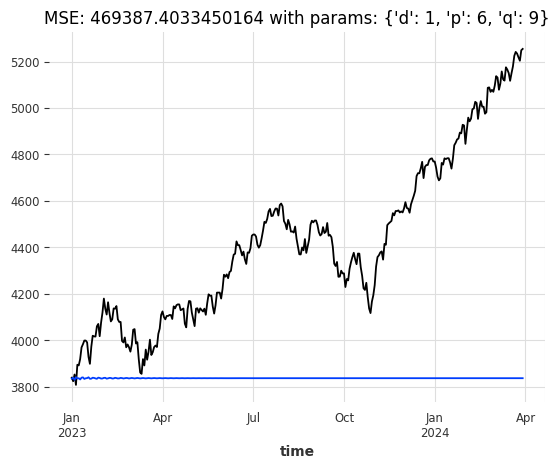

Iter: 5 took 8.088129997253418 with params {'d': 1, 'p': 6, 'q': 9}
--------------------------------------------------


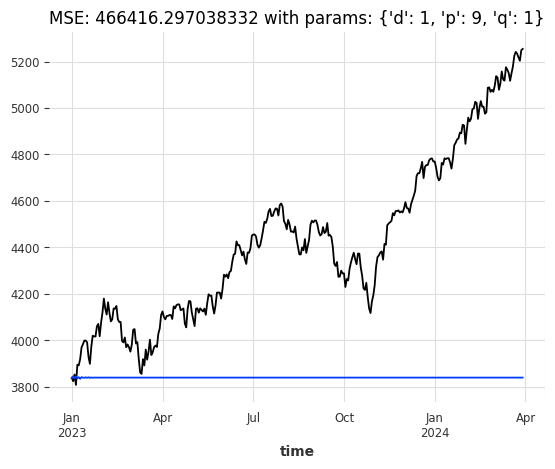

Iter: 6 took 1.8569552898406982 with params {'d': 1, 'p': 9, 'q': 1}
--------------------------------------------------


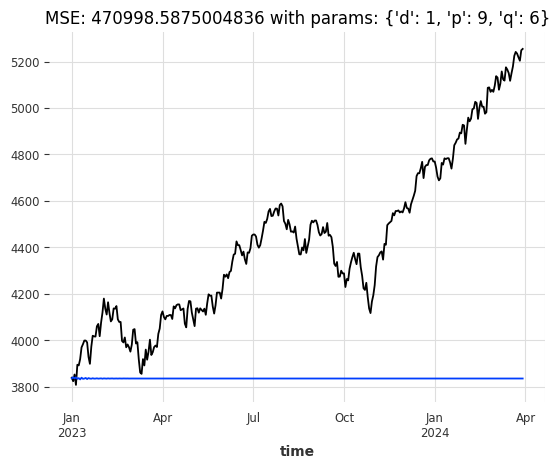

Iter: 7 took 6.946548223495483 with params {'d': 1, 'p': 9, 'q': 6}
--------------------------------------------------


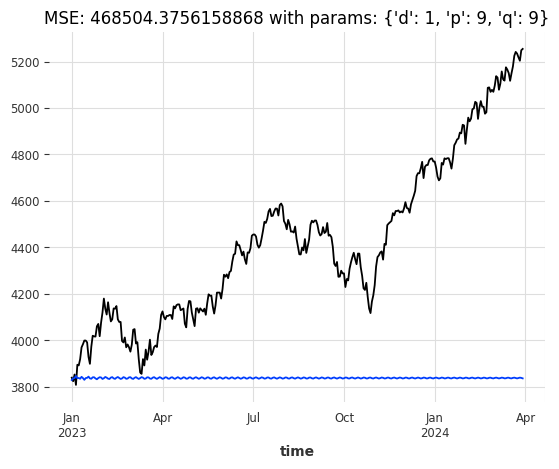

Iter: 8 took 10.613906860351562 with params {'d': 1, 'p': 9, 'q': 9}
--------------------------------------------------


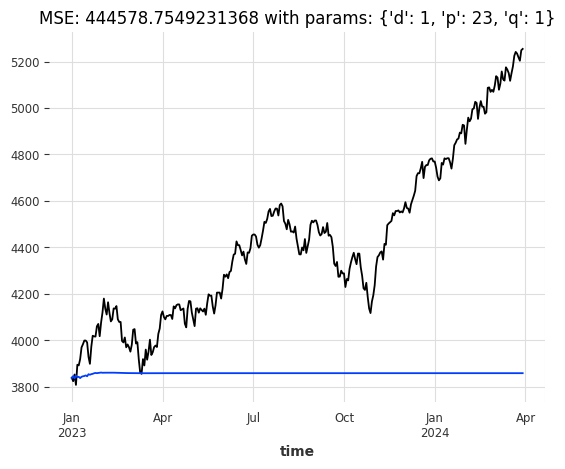

Iter: 9 took 20.13822603225708 with params {'d': 1, 'p': 23, 'q': 1}
--------------------------------------------------


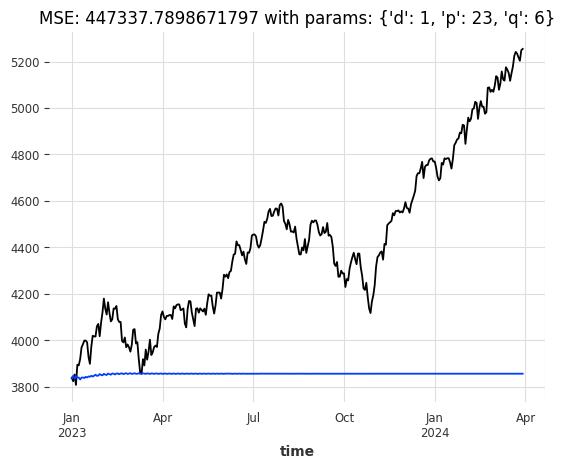

Iter: 10 took 42.49198627471924 with params {'d': 1, 'p': 23, 'q': 6}
--------------------------------------------------


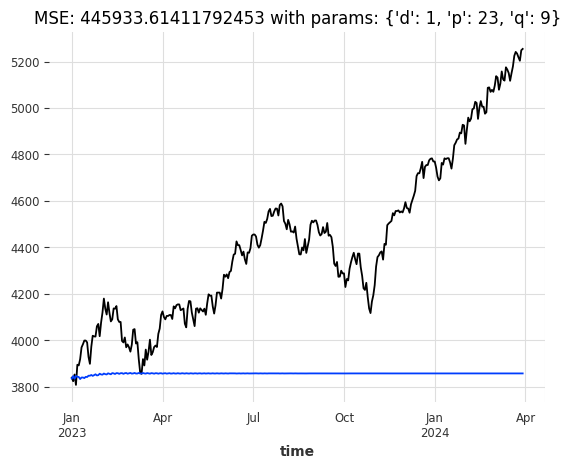

Iter: 11 took 45.968629121780396 with params {'d': 1, 'p': 23, 'q': 9}
--------------------------------------------------


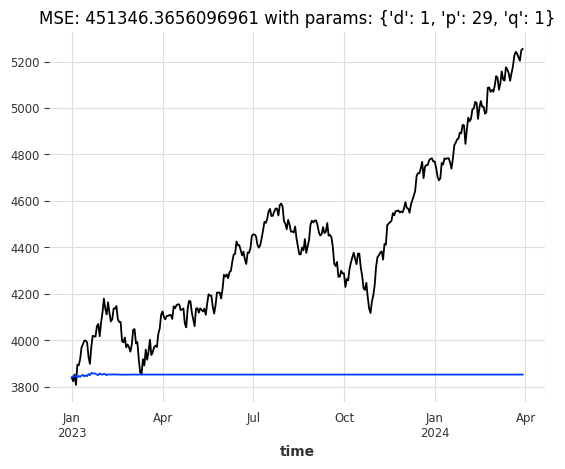

Iter: 12 took 62.303364992141724 with params {'d': 1, 'p': 29, 'q': 1}
--------------------------------------------------


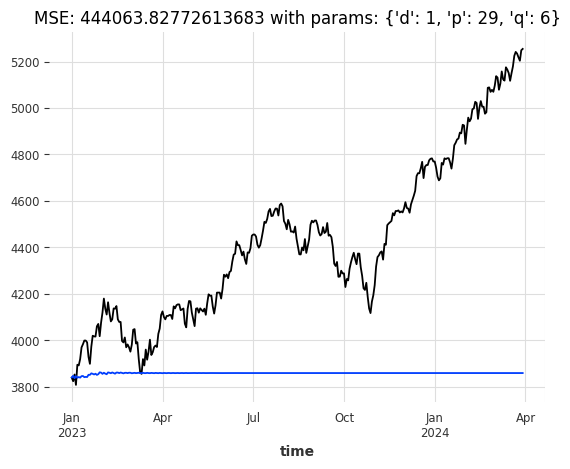

Iter: 13 took 67.95047807693481 with params {'d': 1, 'p': 29, 'q': 6}
--------------------------------------------------


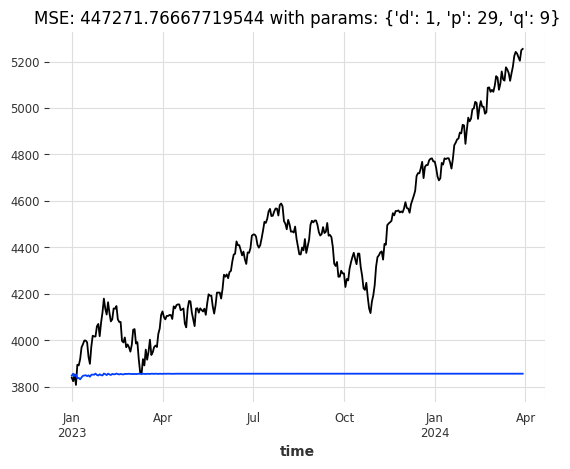

Iter: 14 took 71.82678294181824 with params {'d': 1, 'p': 29, 'q': 9}
--------------------------------------------------


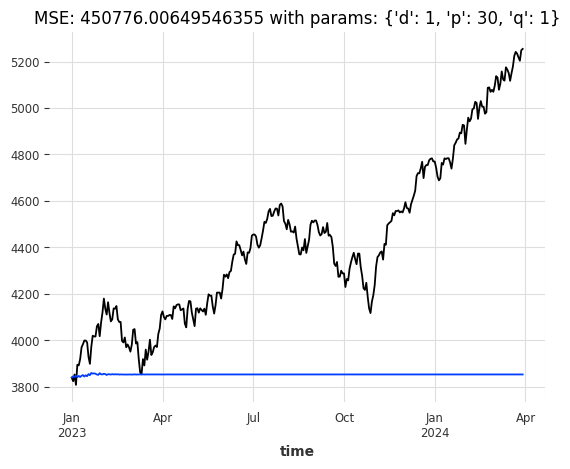

Iter: 15 took 68.84638690948486 with params {'d': 1, 'p': 30, 'q': 1}
--------------------------------------------------


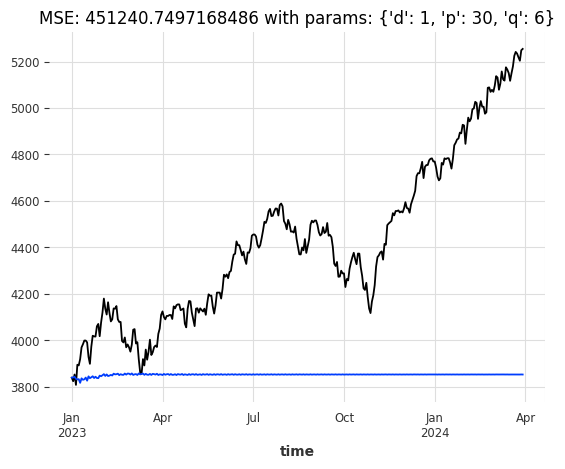

Iter: 16 took 85.50724005699158 with params {'d': 1, 'p': 30, 'q': 6}
--------------------------------------------------


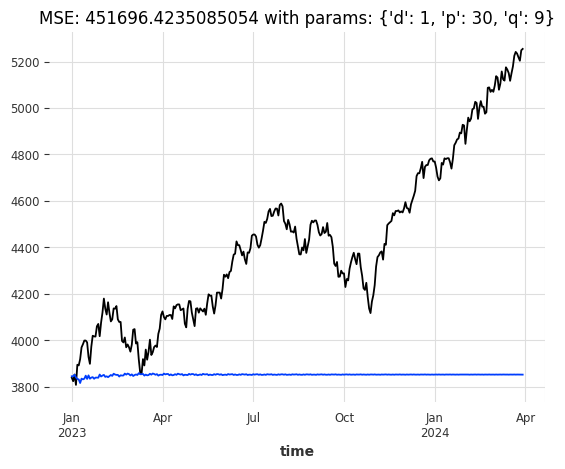

Iter: 17 took 89.91042590141296 with params {'d': 1, 'p': 30, 'q': 9}
--------------------------------------------------


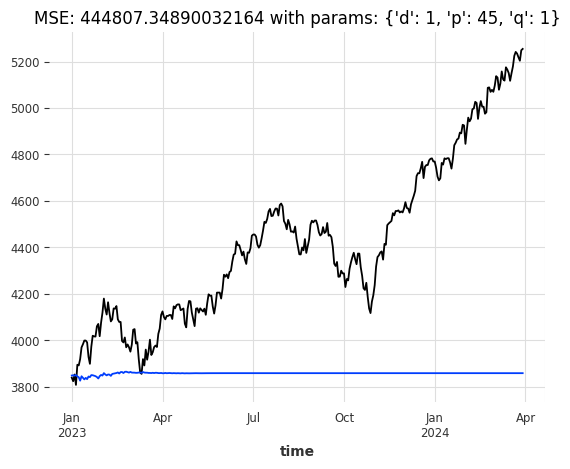

Iter: 18 took 52.85984826087952 with params {'d': 1, 'p': 45, 'q': 1}
--------------------------------------------------


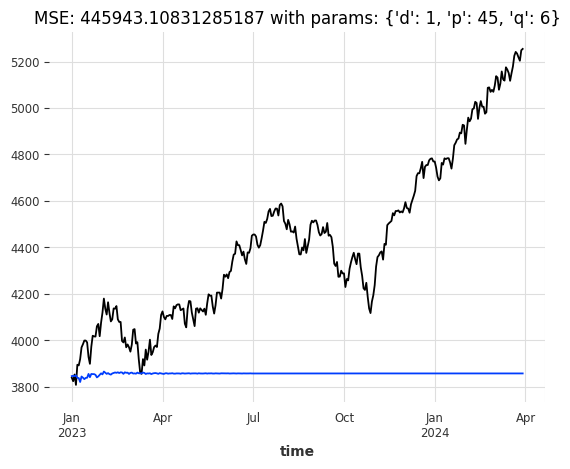

Iter: 19 took 206.04577589035034 with params {'d': 1, 'p': 45, 'q': 6}
--------------------------------------------------


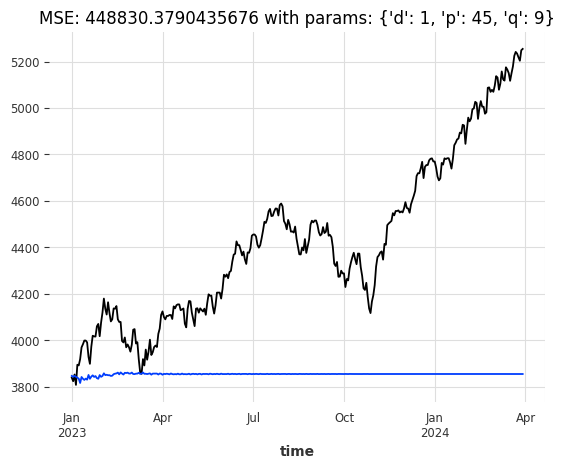

Iter: 20 took 316.8048439025879 with params {'d': 1, 'p': 45, 'q': 9}
--------------------------------------------------


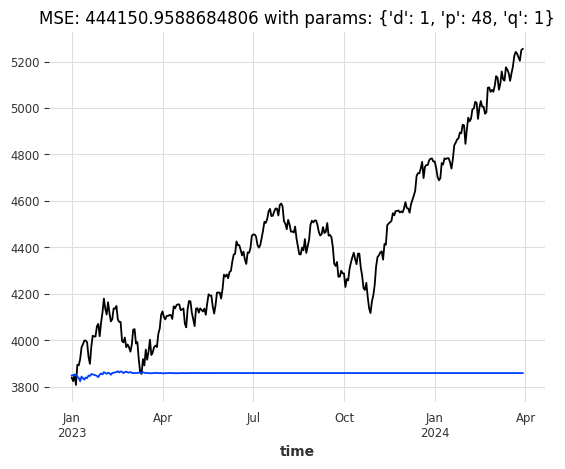

Iter: 21 took 172.13644313812256 with params {'d': 1, 'p': 48, 'q': 1}
--------------------------------------------------


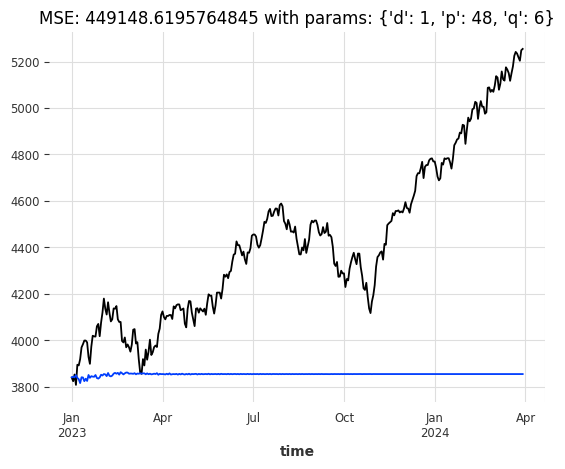

Iter: 22 took 399.164519071579 with params {'d': 1, 'p': 48, 'q': 6}
--------------------------------------------------


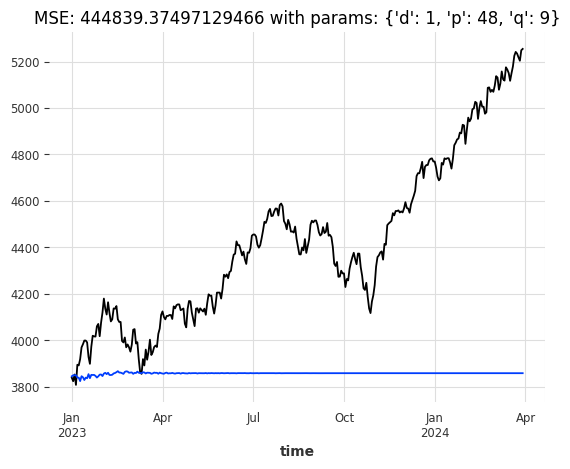

Iter: 23 took 371.89952421188354 with params {'d': 1, 'p': 48, 'q': 9}
--------------------------------------------------


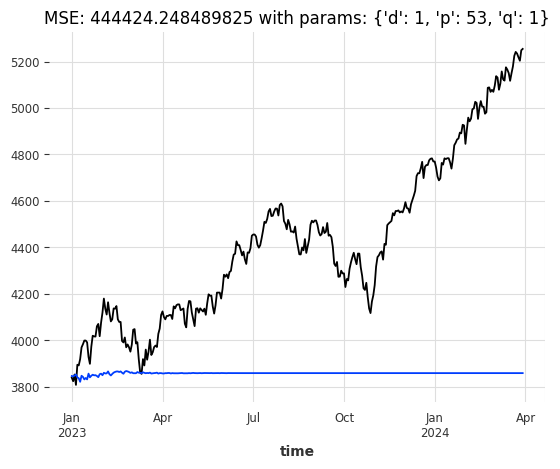

Iter: 24 took 119.09927082061768 with params {'d': 1, 'p': 53, 'q': 1}
--------------------------------------------------


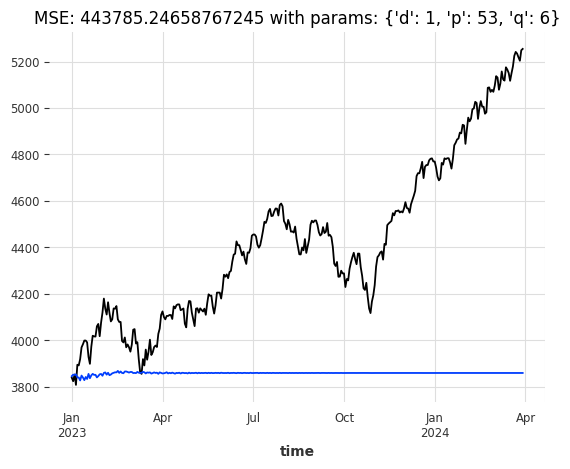

Iter: 25 took 373.52609515190125 with params {'d': 1, 'p': 53, 'q': 6}
--------------------------------------------------


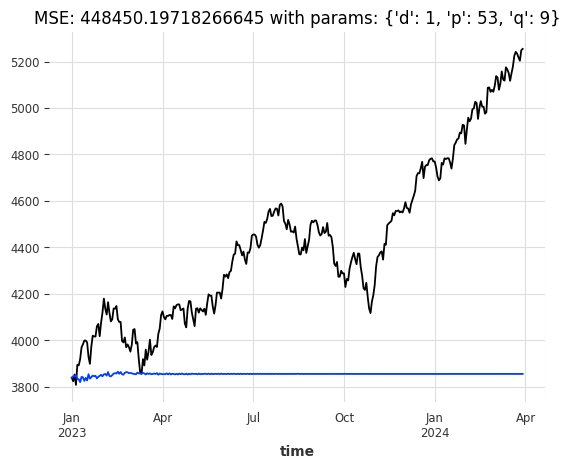

Iter: 26 took 309.56894516944885 with params {'d': 1, 'p': 53, 'q': 9}
--------------------------------------------------


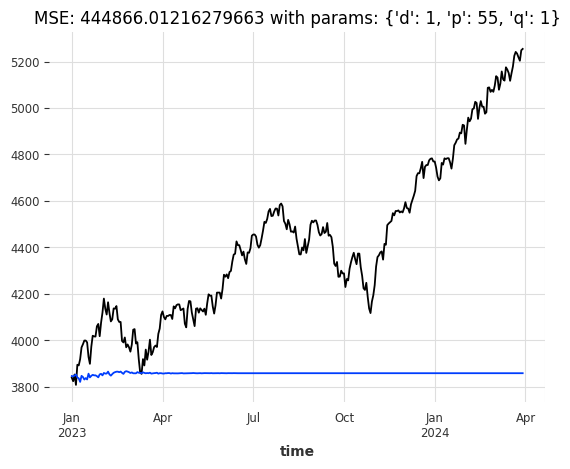

Iter: 27 took 92.2031991481781 with params {'d': 1, 'p': 55, 'q': 1}
--------------------------------------------------


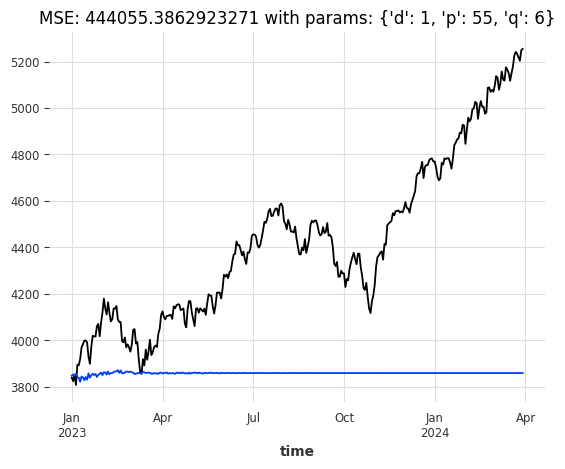

Iter: 28 took 2204.8635268211365 with params {'d': 1, 'p': 55, 'q': 6}
--------------------------------------------------


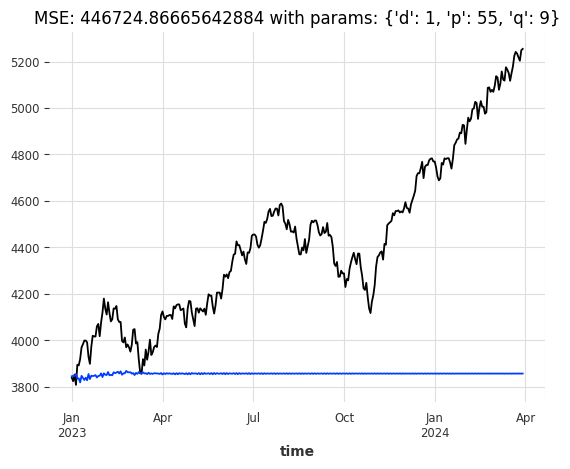

Iter: 29 took 467.20956087112427 with params {'d': 1, 'p': 55, 'q': 9}
--------------------------------------------------


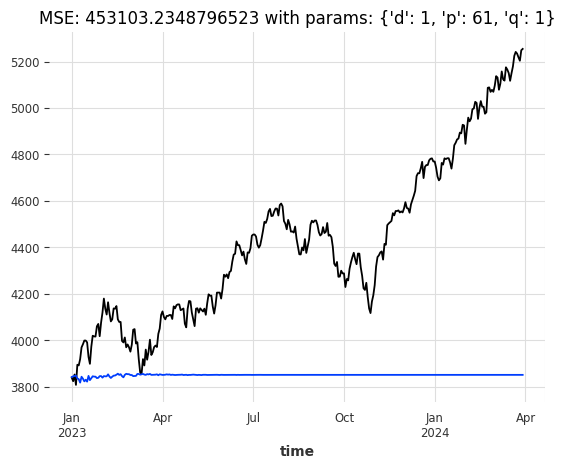

Iter: 30 took 126.97003102302551 with params {'d': 1, 'p': 61, 'q': 1}
--------------------------------------------------


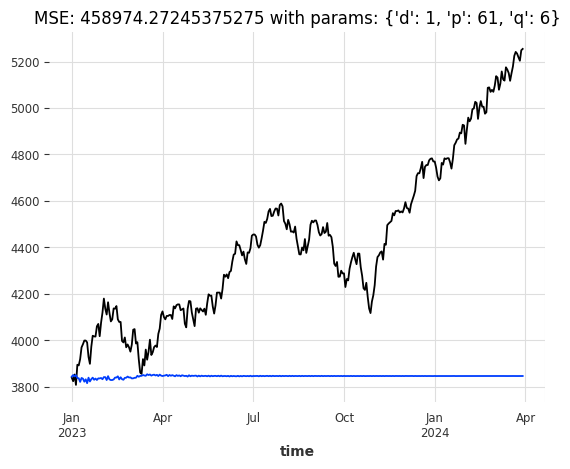

Iter: 31 took 533.8380777835846 with params {'d': 1, 'p': 61, 'q': 6}
--------------------------------------------------


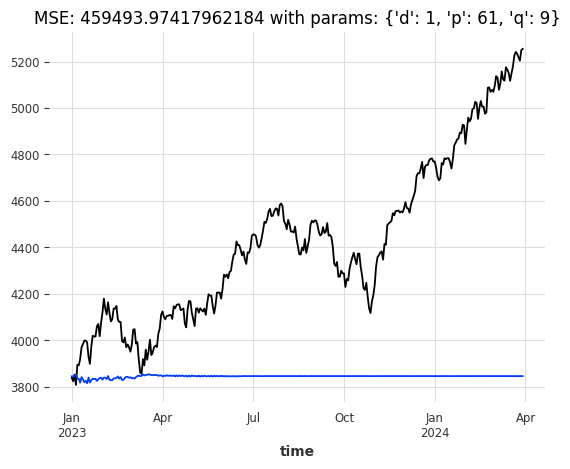

Iter: 32 took 800.4807460308075 with params {'d': 1, 'p': 61, 'q': 9}
--------------------------------------------------


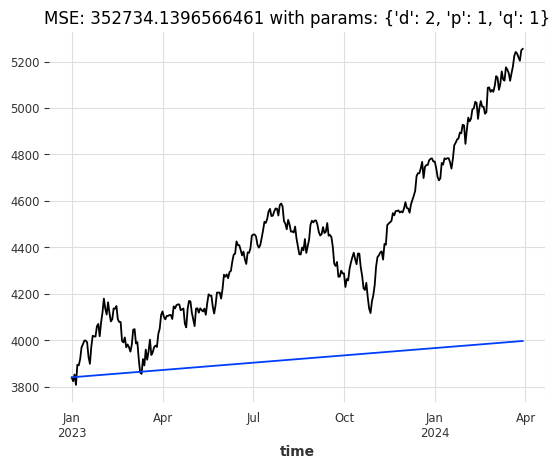

Iter: 33 took 1.0750751495361328 with params {'d': 2, 'p': 1, 'q': 1}
--------------------------------------------------


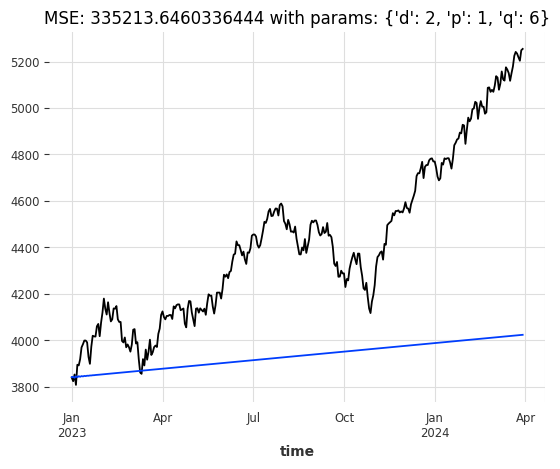

Iter: 34 took 5.5578389167785645 with params {'d': 2, 'p': 1, 'q': 6}
--------------------------------------------------


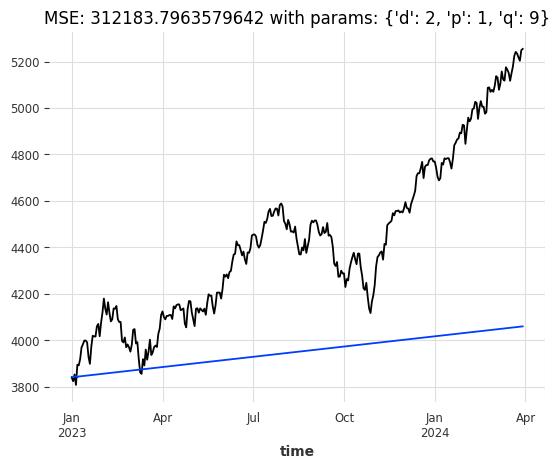

Iter: 35 took 11.328284978866577 with params {'d': 2, 'p': 1, 'q': 9}
--------------------------------------------------


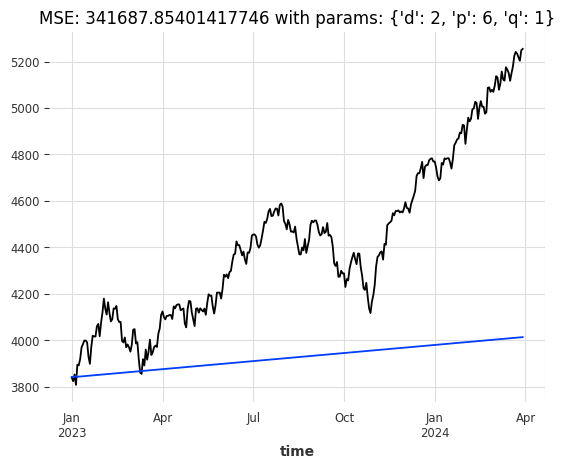

Iter: 36 took 3.2670350074768066 with params {'d': 2, 'p': 6, 'q': 1}
--------------------------------------------------


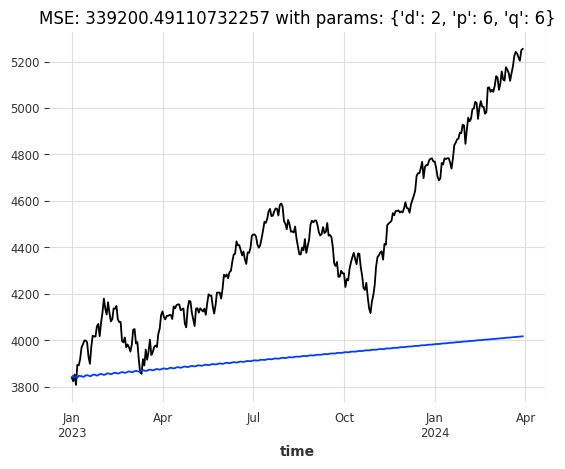

Iter: 37 took 7.812275171279907 with params {'d': 2, 'p': 6, 'q': 6}
--------------------------------------------------


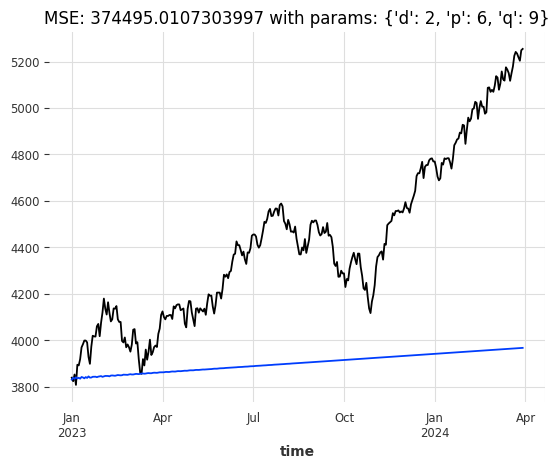

Iter: 38 took 17.15077781677246 with params {'d': 2, 'p': 6, 'q': 9}
--------------------------------------------------


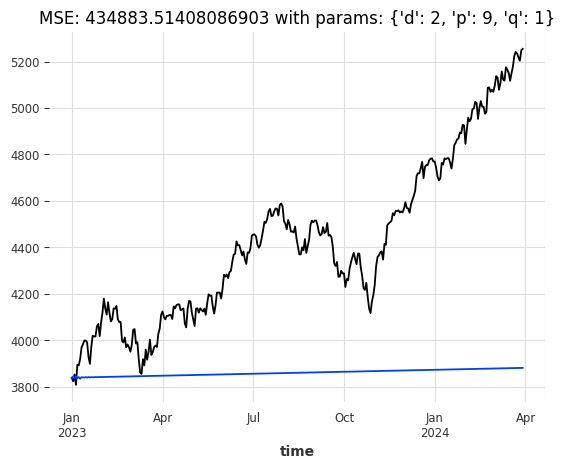

Iter: 39 took 6.1352880001068115 with params {'d': 2, 'p': 9, 'q': 1}
--------------------------------------------------


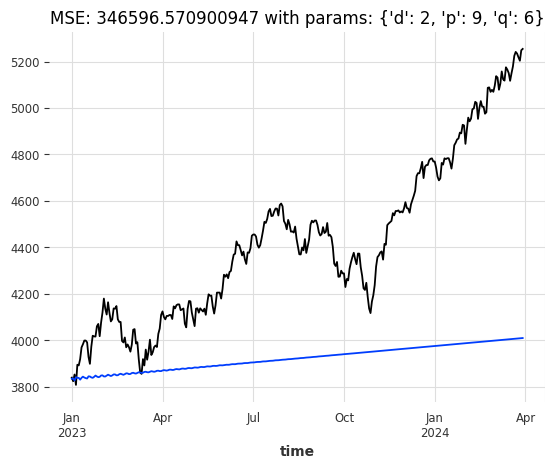

Iter: 40 took 10.390169858932495 with params {'d': 2, 'p': 9, 'q': 6}
--------------------------------------------------


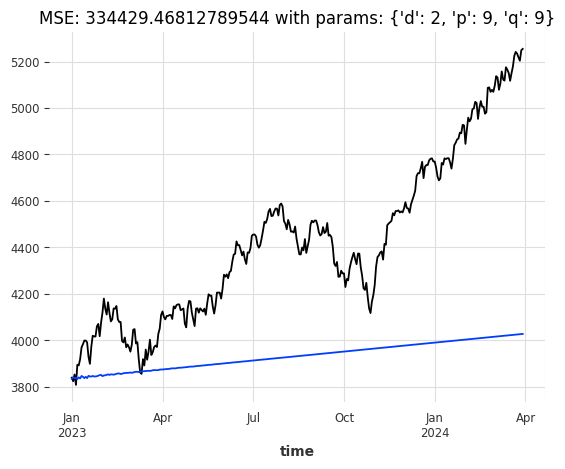

Iter: 41 took 16.89889883995056 with params {'d': 2, 'p': 9, 'q': 9}
--------------------------------------------------


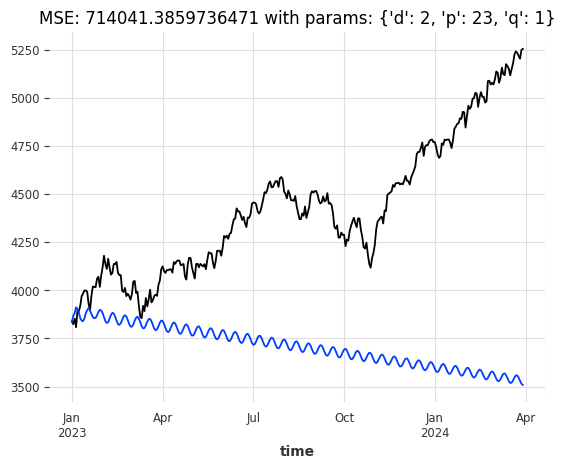

Iter: 42 took 52.307170152664185 with params {'d': 2, 'p': 23, 'q': 1}
--------------------------------------------------


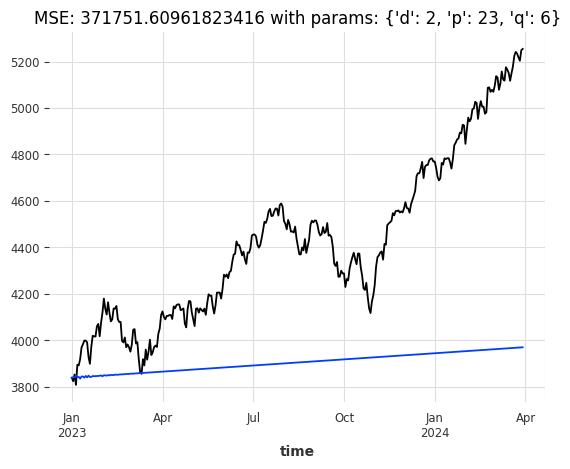

Iter: 43 took 120.64950203895569 with params {'d': 2, 'p': 23, 'q': 6}
--------------------------------------------------


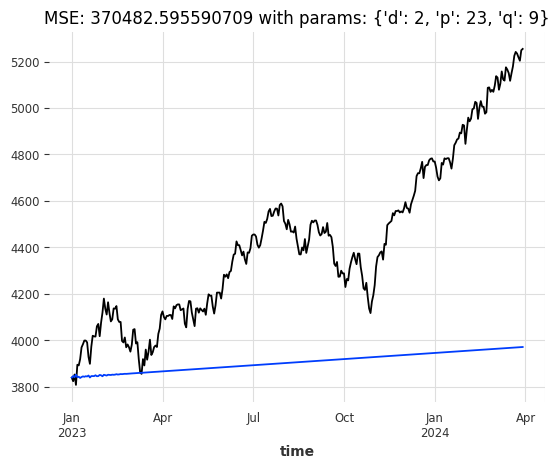

Iter: 44 took 121.27061676979065 with params {'d': 2, 'p': 23, 'q': 9}
--------------------------------------------------


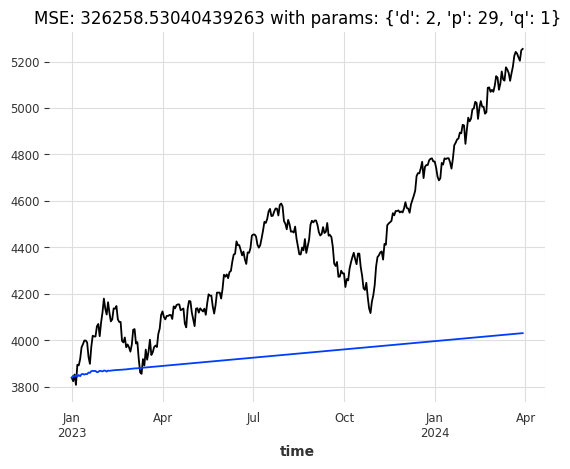

Iter: 45 took 103.26628422737122 with params {'d': 2, 'p': 29, 'q': 1}
--------------------------------------------------


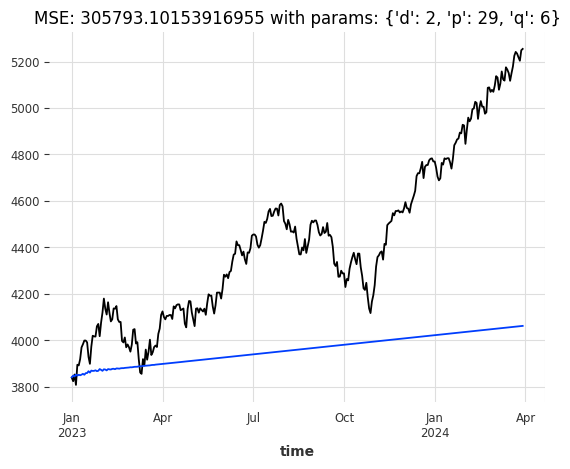

Iter: 46 took 163.7319839000702 with params {'d': 2, 'p': 29, 'q': 6}
--------------------------------------------------


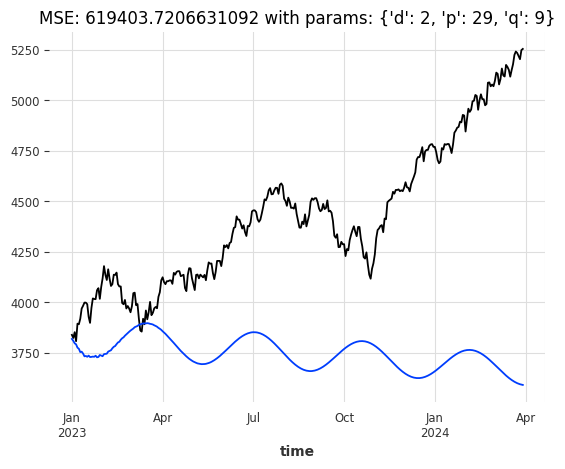

Iter: 47 took 101.99550604820251 with params {'d': 2, 'p': 29, 'q': 9}
--------------------------------------------------


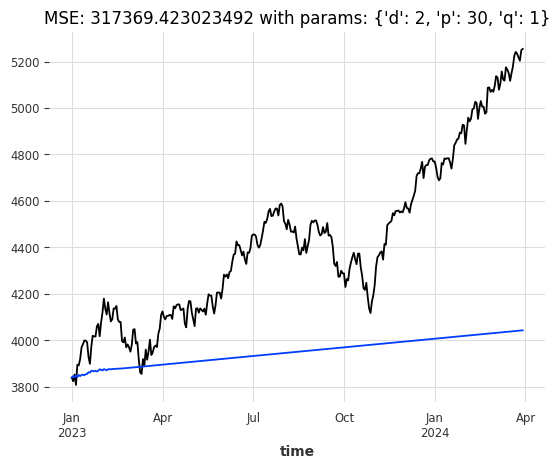

Iter: 48 took 95.54170799255371 with params {'d': 2, 'p': 30, 'q': 1}
--------------------------------------------------


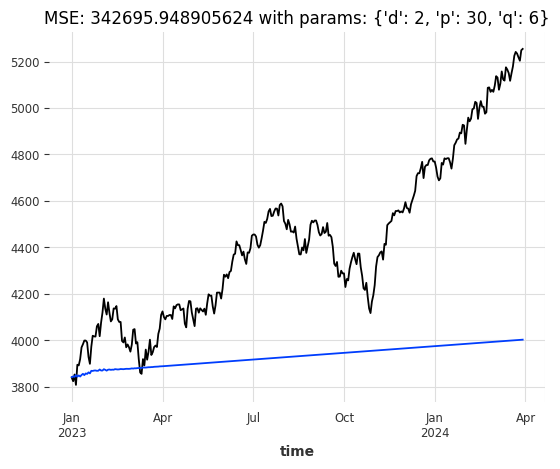

Iter: 49 took 153.68418788909912 with params {'d': 2, 'p': 30, 'q': 6}
--------------------------------------------------


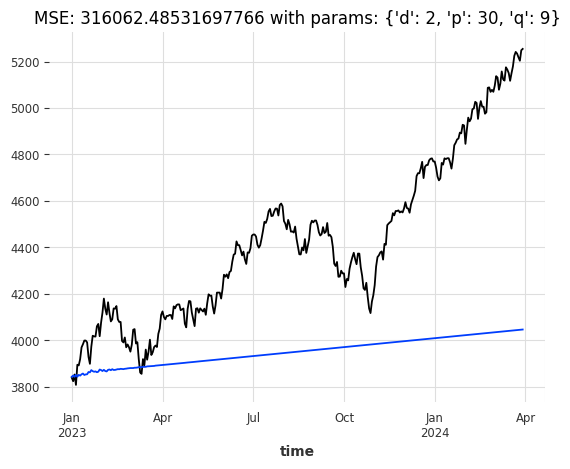

Iter: 50 took 164.6970818042755 with params {'d': 2, 'p': 30, 'q': 9}
--------------------------------------------------


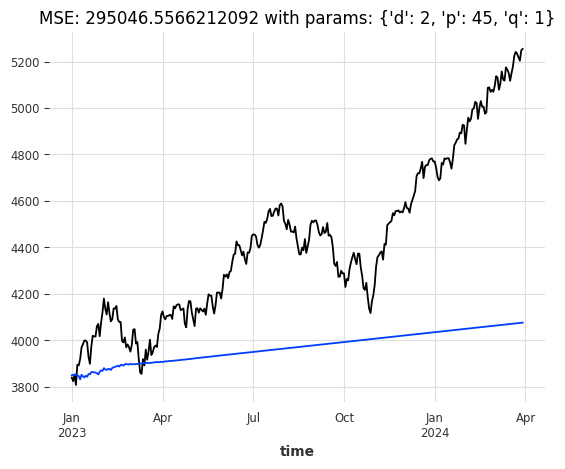

Iter: 51 took 355.9896399974823 with params {'d': 2, 'p': 45, 'q': 1}
--------------------------------------------------


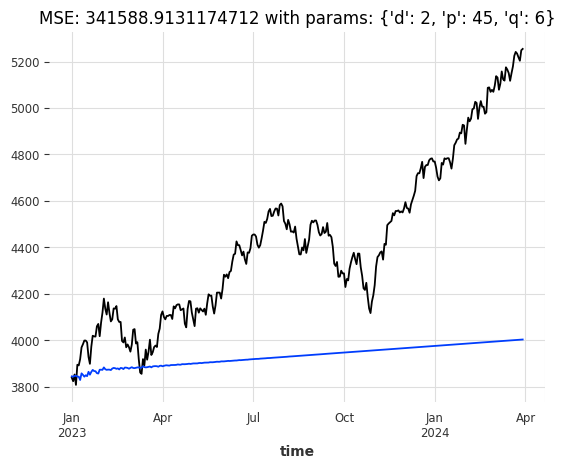

Iter: 52 took 520.8805241584778 with params {'d': 2, 'p': 45, 'q': 6}
--------------------------------------------------


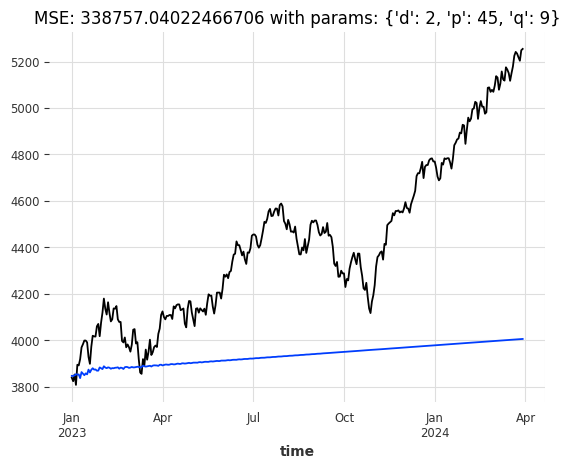

Iter: 53 took 573.8299927711487 with params {'d': 2, 'p': 45, 'q': 9}
--------------------------------------------------


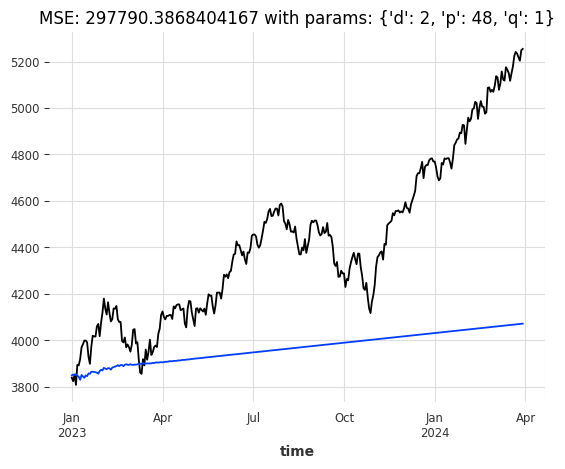

Iter: 54 took 374.1855537891388 with params {'d': 2, 'p': 48, 'q': 1}
--------------------------------------------------


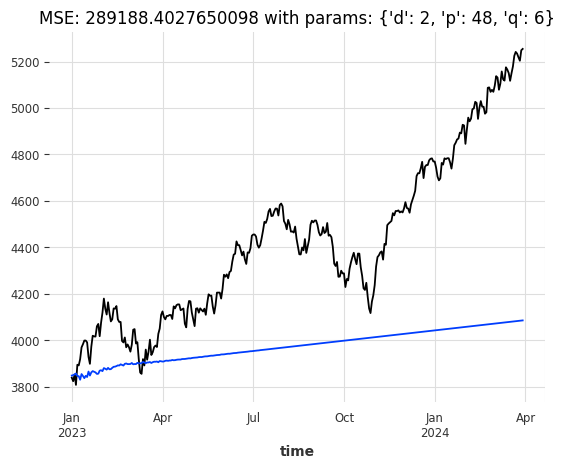

Iter: 55 took 607.3873291015625 with params {'d': 2, 'p': 48, 'q': 6}
--------------------------------------------------


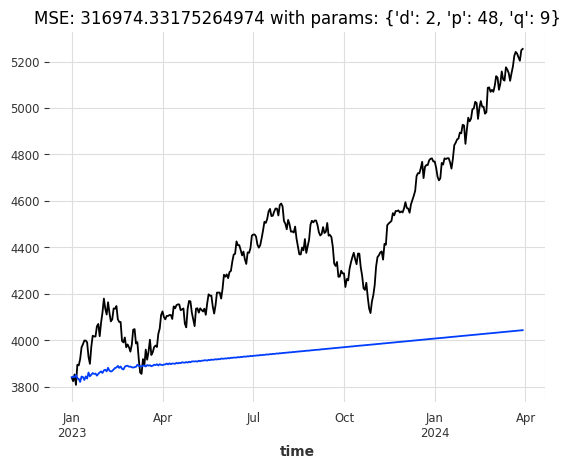

Iter: 56 took 640.6187751293182 with params {'d': 2, 'p': 48, 'q': 9}
--------------------------------------------------


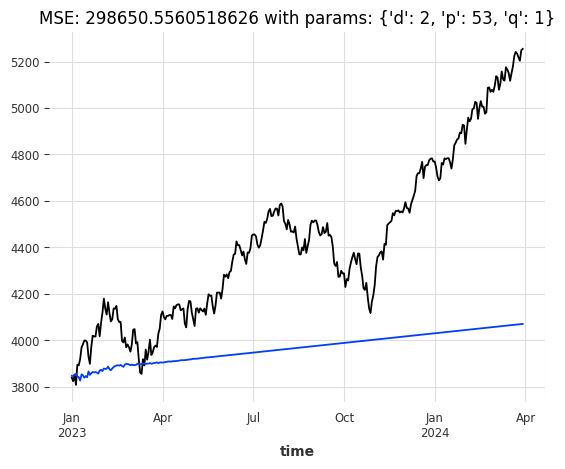

Iter: 57 took 469.11850905418396 with params {'d': 2, 'p': 53, 'q': 1}
--------------------------------------------------


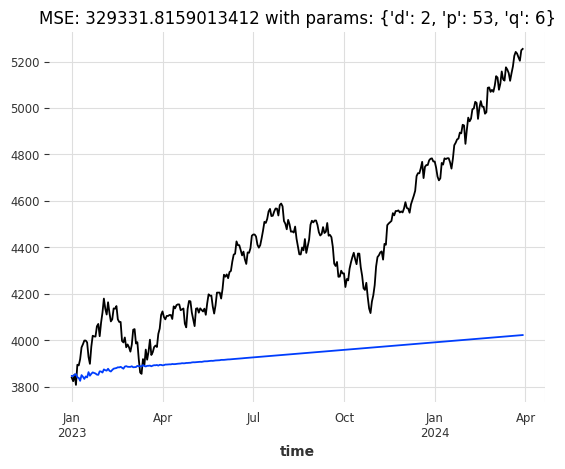

Iter: 58 took 845.3389151096344 with params {'d': 2, 'p': 53, 'q': 6}
--------------------------------------------------


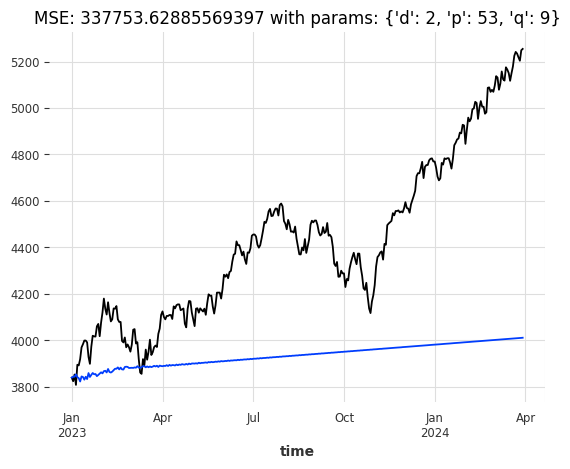

Iter: 59 took 2278.2182490825653 with params {'d': 2, 'p': 53, 'q': 9}
--------------------------------------------------


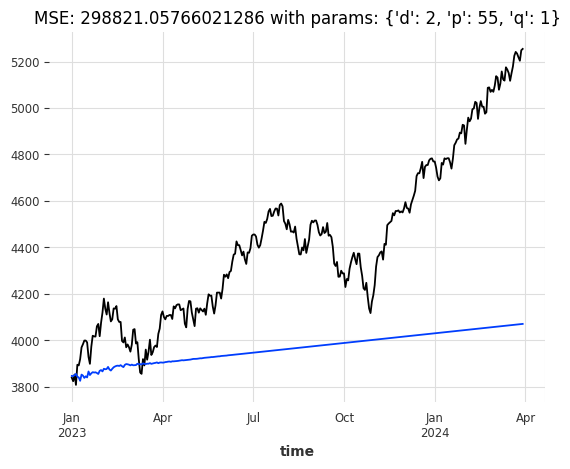

Iter: 60 took 4597.096088886261 with params {'d': 2, 'p': 55, 'q': 1}
--------------------------------------------------


KeyboardInterrupt: 

In [4]:
from sklearn.model_selection import ParameterGrid
import time

def get_forecast(params, train, test):
    model = ARIMA(train, order=(params['p'], params['d'], params['q']))
    results = model.fit()

    prediction = results.forecast(len(test))
    prediction.index = test.index
    return prediction

def get_mse(test, prediction):
    mse = sum([(y-yp)**2 for y,yp in zip(test,prediction)])/len(test)
    return mse

def plot_predictions(test, prediction, params, error):
    test.plot(label="Test")
    prediction.plot(label="Prediction")
    plt.autoscale()
    plt.title(f"MSE: {error} with params: {str(params)}")
    plt.show()


def get_best_params(data):
    df_timeseries = TimeSeries.from_series(data)
    split_date = pd.Timestamp('2023-01-01')
    train_data, test_data = df_timeseries.split_before(split_date)
    train_data, test_data = train_data.pd_series(), test_data.pd_series()

    param_grid = ParameterGrid({
        'p': [1,6,9,23,29,30,45,48,53,55,61],#62,64,65,71,72,74,75,77,81,90,100],
        'd': [1,2],
        'q': [1, 6, 9, ],#, 14, 15, 16, 24, 28, 34, 35, 37, 50, 53, 58, 60], #65, 66, 69, 71, 72, 75, 80, 85, 87, 94]
    })

    results={}
    for i,params in enumerate(param_grid):
        print('-'*50)
        start = time.time()
        with open('ARIMA_params.txt', 'a') as f:
            stringified_params = ''.join([f'{str(key)} : {str(params[key])}\n' for key in params.keys()])
            text = f"{'-'*50}\n{stringified_params}\n"
            f.write(text)

            prediction = get_forecast(params, train_data, test_data)
            error = get_mse(test_data, prediction) # MSE
            plot_predictions(test_data,prediction,params,error)
            
            f.write(f'MSE: {error}\n')
            results[error] = params

            elapsed_time = time.time()-start
            f.write(f"Time: {elapsed_time}\n")

        # Write the results every time in case an error occurs
        with open('ARIMA_results.txt','w') as f:
            # Convert to str for future processing
            stringified_results = {str(key): {p_key: p_value for p_key,p_value in results[key].items()} for key in results.keys()}
            f.write(str(stringified_results))
        
        print(f"Iter: {i} took {elapsed_time} with params {params}")

get_best_params(df.market_value)

## ARIMA on the entire dataset

In [ ]:
len_ds = len(df.market_value)

df_timeseries = TimeSeries.from_dataframe(df, time_col=None, value_cols=['market_value'], fill_missing_dates=False, freq='B')
split_date = pd.Timestamp('2000-01-01')
train, test = df_timeseries.split_before(split_date)

train_series,test_series = train.pd_series(), test.pd_series()
model = ARIMA(train_series, order=(8,1,8))
results = model.fit()

# Predict the entire dataset
predictions = results.predict(start=train_series.index[0], end=test_series.index[-1])
predictions_series = pd.Series(predictions, index=df.index)
error = np.sum(np.array([(y-yp)**2 for y,yp in zip(df.market_value,predictions)]))/len(test_series)

# Predict only the test dataset
# predictions = results.predict(start=test_series.index[0], end=test_series.index[-1])
# predictions_series = pd.Series(prediction, index=df.index)
# error = np.sum(np.array([(y-yp)**2 for y,yp in zip(test_series,predictions)]))/len(test_series)

plt.figure(figsize=(25,10))
train_series.plot(label="Train",lw=1)
test_series.plot(label="Test",lw=1)
predictions.plot(label="Prediction", color='red', lw=0.6)

plt.title(f"MSE: {error}")
plt.legend()
plt.show()

## Forecast one day at a time

In [ ]:
train_len = int(len(df)*0.95)
train_series, test_series = df.market_value[0:train_len], df.market_value[train_len:]
train_list, test_list = list(train_series), list(test_series)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Price')
train_series.plot(label='Train data')
test_series.plot(label='Test data')
plt.legend()
plt.show()

In [ ]:
predictions = []
test_len = len(test_list)

for i in range(test_len):
    if i%10==0:
        print(f"Iter {i}: {i*100/test_len}%")
    model = ARIMA(train_list, order=(4,1,2))
    results = model.fit()
    yhat = results.forecast()[0]
    predictions.append(yhat)
    train_list.append(test_list[i])

In [ ]:
predictions_copy = predictions.copy()
predictions_series = pd.Series(data=predictions_copy, index=test_series.index)

plt.figure(figsize=(20,10))
test_series.plot(label="Test Data", linestyle='dashed', color='blue')
predictions_series.plot(label="Predictions", color='red')
plt.legend()
plt.show()

## Find the best Parameters for ARIMA using ACF and PACF on returns

In [ ]:
plt.figure(figsize=(15,10))
sgt.plot_acf(df.returns, lags=60, alpha=0.05, zero=False)
plt.autoscale()
plt.title('ACF for Returns')
plt.show()

plt.figure(figsize=(15,10))
sgt.plot_pacf(df.returns, lags=60, alpha=0.05, zero=False)
plt.autoscale()
plt.title('PACF for Returns')
plt.show()


In [ ]:
train_len = int(len(df)*0.95)
train_series, test_series = df.returns[0:train_len], df.returns[train_len:]
train_list, test_list = list(train_series), list(test_series)
model = ARIMA(train_series, order=(8,0,6))
results = model.fit()
ret_predictions = results.forecast(steps=len(test_series))
ret_predictions_series = pd.Series(data=ret_predictions, index=test_series.index)
print(results.summary())

plt.figure(figsize=(20,10))
test_series.plot(label="Test Data", linestyle='dashed', color='blue')
ret_predictions_series.plot(label="Predictions", color='red')
plt.legend()
plt.show()